In [30]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

# Double DQN

In [31]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [32]:
class DQN:
    """ DQN & Double DQN Algorithm. """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            # state = torch.tensor([state], dtype=torch.float).to(self.device)
            # state = torch.from_numpy(np.expand_dims(state, axis=0)).float().to(self.device)
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = F.mse_loss(q_values, q_targets)

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        
        self.count += 1

In [43]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11

def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

In [34]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                reset_output = env.reset()
                state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
                done = False
                while not done:
                    # Sampling
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    action_continuous = dis_to_con(action, env, action_dim)
                    next_state, reward, terminated, truncated, info = env.step([action_continuous])
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    
                    # Training
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'rewards': b_r,
                            'next_states': b_ns,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                
                return_list.append(episode_return)
                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % (np.mean(return_list[-10:]))
                    })
                pbar.update(1)
    return return_list, max_q_value_list

### DQN Results

In [35]:
seed = 0
random.seed(seed)
np.random.seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s, episode=200, return=-191.075]


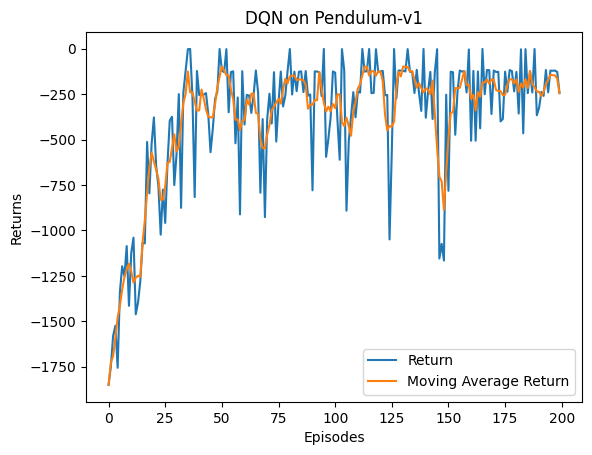

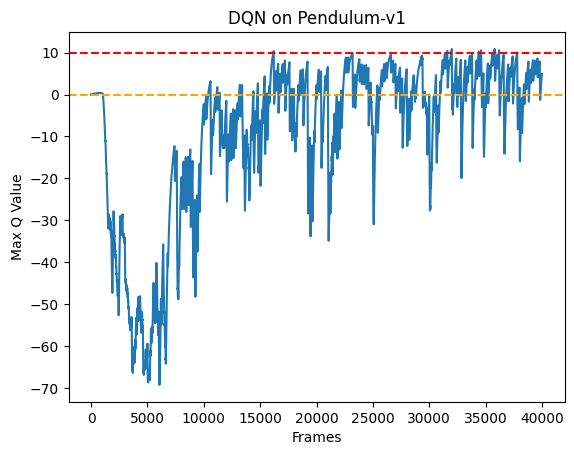

In [36]:

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, return_list, label='Return')
plt.plot(episodes_list, mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Max Q Value')
plt.title('DQN on {}'.format(env_name))
plt.show()

### Double DQN Results

In [37]:
seed = 0
random.seed(seed)
np.random.seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, dqn_type='DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s, episode=200, return=-188.734]


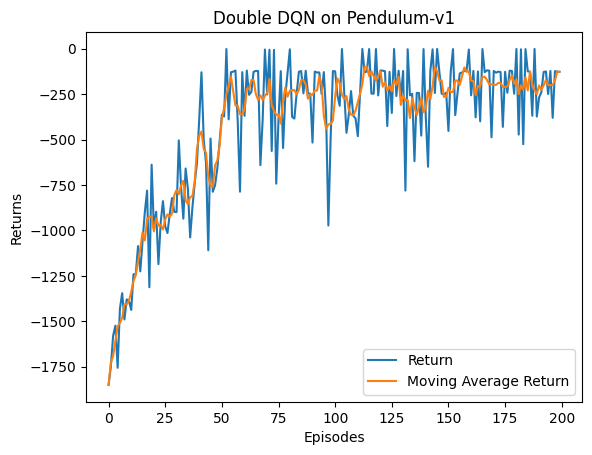

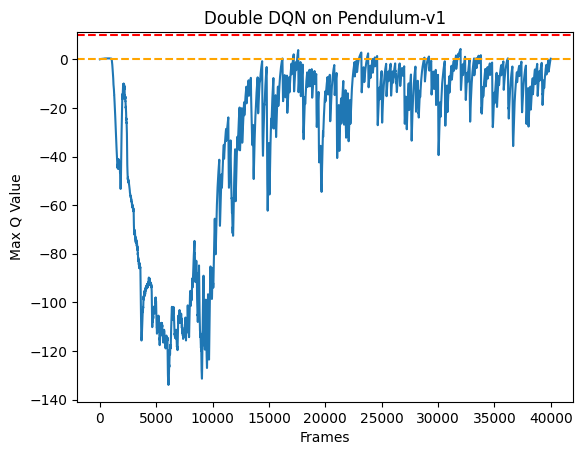

In [38]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, return_list, label='Return')
plt.plot(episodes_list, mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Max Q Value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

# Dueling DQN

In [48]:
class VAnet(torch.nn.Module):
    """ A-net and V-net with one hidden layer. """
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_A = nn.Linear(hidden_dim, action_dim)
        self.fc_V = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # A = self.fc_A(F.relu(self.fc1(x)))
        # V = self.fc_V(F.relu(self.fc1(x)))
        # if x.dim() == 1:
        #     x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
        A = self.fc_A(x)
        V = self.fc_V(x)
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

In [52]:
class DQN:
    """ DQN & Double DQN & Dueling DQN Algorithm."""
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device
        
        if dqn_type == 'DuelingDQN':
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        
        dqn_loss = F.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [53]:
seed = 0
random.seed(seed)
np.random.seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, dqn_type='DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)


Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s, episode=200, return=-224.688]


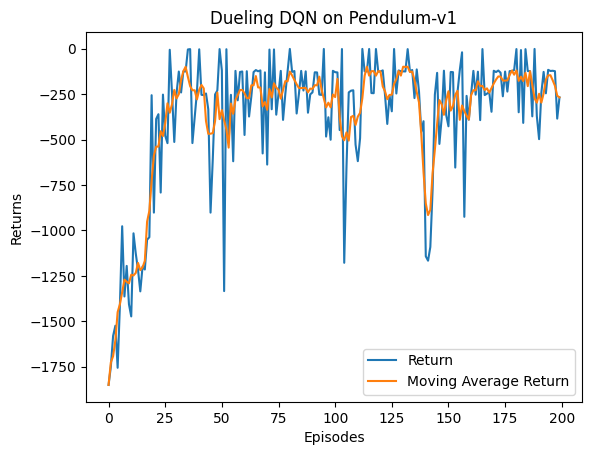

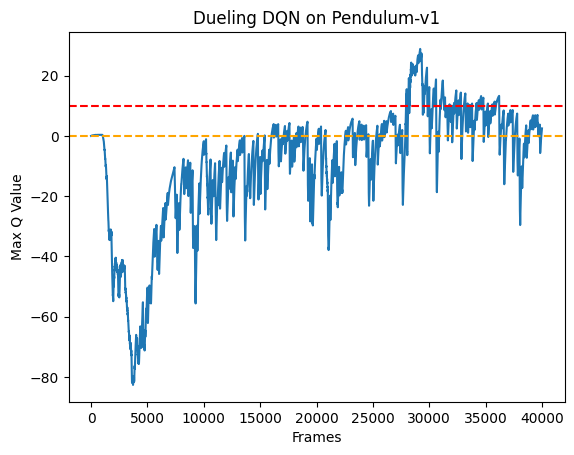

In [54]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, return_list, label='Return')
plt.plot(episodes_list, mv_return, label='Moving Average Return')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Max Q Value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()